Evaluate the impact of a silver-coated mirror vs. an aluminum-coated mirror.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import pandas as pd
from rubin_sim.phot_utils import Bandpass
import syseng_throughputs as st

In [2]:
defaultDirs = st.setDefaultDirs()
defaultDirs

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}

In [3]:
srd = True
readnoise = np.array([6.8, 8.8, 16])
noise = np.sqrt(readnoise**2 + 0.2*15)
print(noise)
readnoise = 8.8

# srd true = no losses, X=1.0, fwhm500 = 0.62
# srd false = losses, X=1.2, fwhm500 = 0.72
if srd:
    addLosses = False
else:
    addLosses = True

[ 7.01712192  8.96883493 16.09347694]


In [4]:
# Read the non-mirror components - with losses or not depending on srd (without) or not (with)
detector = {}
detector['det'] = st.buildDetector(defaultDirs['detector'], addLosses=addLosses)
detector['e2v'] = st.buildDetector('/'.join(defaultDirs['detector'].split('/')[:-1] + ['e2v']), 
                                   addLosses=addLosses)
detector['itl'] = st.buildDetector('/'.join(defaultDirs['detector'].split('/')[:-1] + ['itl']),
                                  addLosses=addLosses)
lens1 = st.buildLens(defaultDirs['lens1'], addLosses=addLosses)
lens2 = st.buildLens(defaultDirs['lens2'], addLosses=addLosses)
lens3 = st.buildLens(defaultDirs['lens3'], addLosses=addLosses)
filters = st.buildFilters(defaultDirs['filters'], addLosses=addLosses)
if srd:
    X=1.0
    atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')
else:
    X=1.2
    atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='pachonModtranAtm_12_aerosol.dat')
    
for det in detector:
    detector[det].resample_bandpass()
lens1.resample_bandpass()
lens2.resample_bandpass()
lens3.resample_bandpass()
atmos.resample_bandpass()
for f in filters:
    filters[f].resample_bandpass()

In [5]:
silver = Bandpass()
silver.read_throughput('ProtAg_6deg.dat')
silver.resample_bandpass()

silver = st.buildMirror(defaultDirs['mirror1'], addLosses=False)
silver.resample_bandpass()

alu = Bandpass()
alu.read_throughput('ProtAl_6deg.dat')
alu.resample_bandpass()

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/phot_utils/bandpass.py:82: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/phot_utils/bandpass.py:82: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


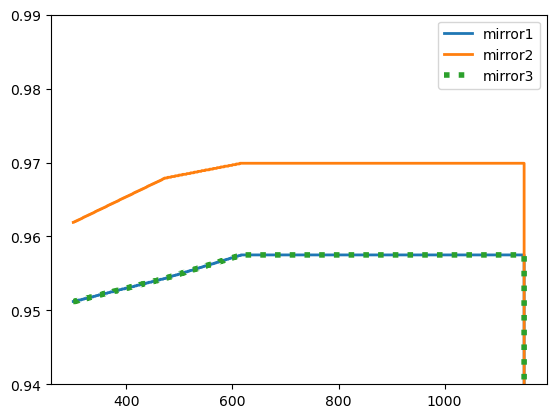

In [6]:
# check if mirror losses are the same ..
losses = {}
for m in ('mirror1', 'mirror2', 'mirror3'):
    losses[m] = Bandpass()
    losses[m].read_throughput(os.path.join(defaultDirs[m], '%s%s_Losses' % (m[0],m[-1]), 
                                          '%s%s_Losses.dat' % (m[0], m[-1])))
    losses[m].resample_bandpass()
    linestyle = '-'
    width=2
    if m == 'mirror3':
        linestyle=':'
        width=4
    plt.plot(losses[m].wavelen, losses[m].sb, linestyle=linestyle, linewidth=width, label=m)
plt.ylim(0.94, 0.99)
plt.legend()

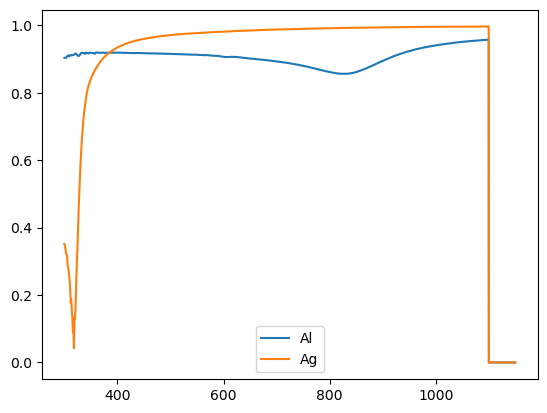

In [7]:
# Mirror losses are not the same (up vs. down-facing), so turn them off for now.
mirror = {}
mirror['Al'] = alu
mirror['Ag'] = silver
# BUT because they are not material dependent and just multiply by the mirror throughput .. 
# we can add them back anyway (as we do below)

for m in mirror:
    mirror[m].resample_bandpass()

plt.plot(mirror['Al'].wavelen, mirror['Al'].sb, label='Al')
plt.plot(mirror['Ag'].wavelen, mirror['Ag'].sb, label='Ag')
plt.legend()

In [8]:
# Ok .. currently looking at just Al-Ag-Al vs. Ag-Ag-Ag
combos = [['Al', 'Ag', 'Al'], ['Ag', 'Ag', 'Ag']]


m5 = {}
system_all = {}
for combo in combos:
    comboname = '-'.join(combo)
    system_all[comboname] = {}
    m5[comboname] = {}
    for det in ['e2v', 'itl']:
        hardware = {}
        system = {}
        for f in filters:
            wavelen = detector[det].wavelen
            # Hardware
            sb = detector[det].sb * lens1.sb * lens2.sb * lens3.sb * filters[f].sb
            if not srd:
                sb *= losses['mirror1'].sb * losses['mirror2'].sb * losses['mirror3'].sb
            sb *= mirror[combo[0]].sb * mirror[combo[1]].sb * mirror[combo[2]].sb
            hardware[f] = Bandpass()
            hardware[f].set_bandpass(wavelen, sb)
            system[f] = Bandpass()
            system[f].set_bandpass(wavelen, sb * atmos.sb)
        system_all[comboname][det] = system
        if srd:
            m5[comboname][det] = st.makeM5(hardware, system, darksky=None, 
                                           exptime=15, nexp=2,
                                           readnoise=8.8, othernoise=0.,
                                           darkcurrent=0.2, fwhm500=0.62, X=1.0)
        else:
            # Default exptime values put u=1x30, grizy = 2x15
            m5[comboname][det] = st.makeM5(hardware, system, darksky=None, 
                                           readnoise=readnoise, othernoise=0.,
                                           darkcurrent=0.2, fwhm500=0.72, X=X)

In [9]:
m5['Al-Ag-Al'].keys()

dict_keys(['e2v', 'itl'])

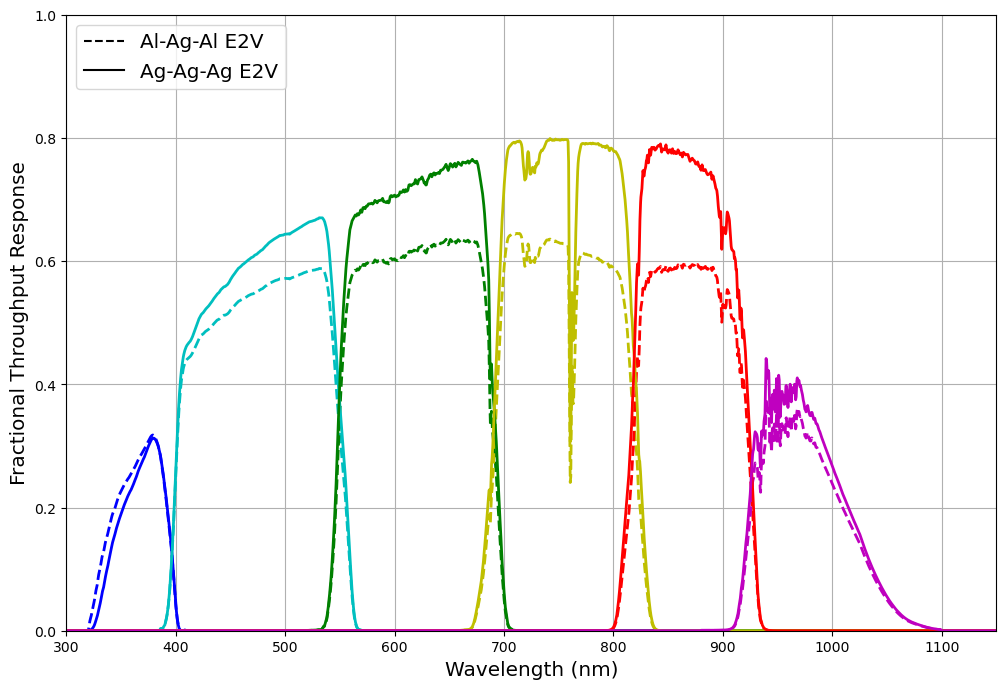

In [10]:
# Plot the entire throughputs
plt.figure(figsize=(12, 8))
linestyles = ['--', '-']
leg_elements = []
for i, combo in enumerate(combos):
    label = '-'.join(combo) + ' E2V'
    linestyle= linestyles[i]
    st.plotBandpasses(system_all['-'.join(combo)]['e2v'], newfig=False, addlegend=False, linestyle=linestyle)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=label))
plt.legend(handles=leg_elements, loc='upper left', fontsize='x-large', fancybox=True)

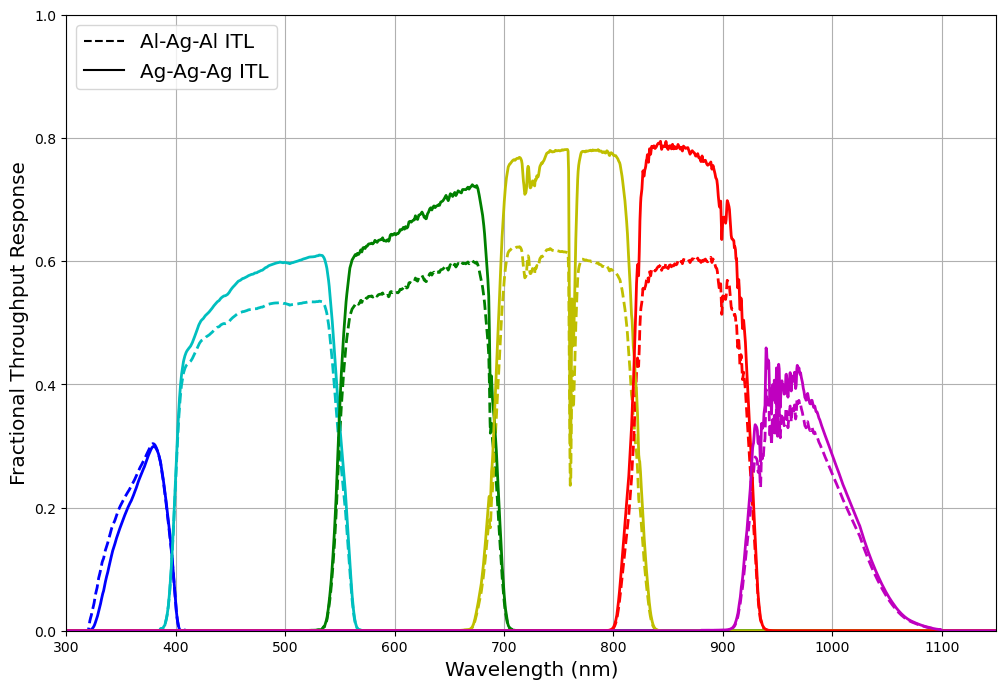

In [11]:
# Plot the entire throughputs
plt.figure(figsize=(12, 8))
linestyles = ['--', '-', '-.', ':']
leg_elements = []
for i, combo in enumerate(combos):
    label = '-'.join(combo) + ' ITL'
    linestyle= linestyles[i]
    st.plotBandpasses(system_all['-'.join(combo)]['itl'], newfig=False, addlegend=False, linestyle=linestyle)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=label))
plt.legend(handles=leg_elements, loc='upper left', fontsize='x-large', fancybox=True)

In [12]:
print('filter vendor Al-Ag-Al Ag-Ag-Ag  ratio')
for f in 'ugrizy':
    for det in ['e2v', 'itl']:
        effwavelenphi1, effwavelensb1 = system_all['Al-Ag-Al'][det][f].calc_eff_wavelen()
        effwavelenphi2, effwavelensb2 = system_all['Ag-Ag-Ag'][det][f].calc_eff_wavelen()
        print(f'{f}    {det}   {effwavelensb1 :.2f}   {effwavelensb2 :.2f}   {(effwavelensb1/effwavelensb2) :.3f}')

filter vendor Al-Ag-Al Ag-Ag-Ag  ratio
u    e2v   366.25   369.48   0.991
u    itl   366.67   369.93   0.991
g    e2v   479.09   480.26   0.998
g    itl   477.84   479.02   0.998
r    e2v   620.65   621.35   0.999
r    itl   621.37   622.08   0.999
i    e2v   754.23   755.44   0.998
i    itl   754.70   755.90   0.998
z    e2v   869.12   867.97   1.001
z    itl   869.48   868.32   1.001
y    e2v   975.70   974.90   1.001
y    itl   976.25   975.45   1.001


Text(0, 0.5, 'Reflectivity')

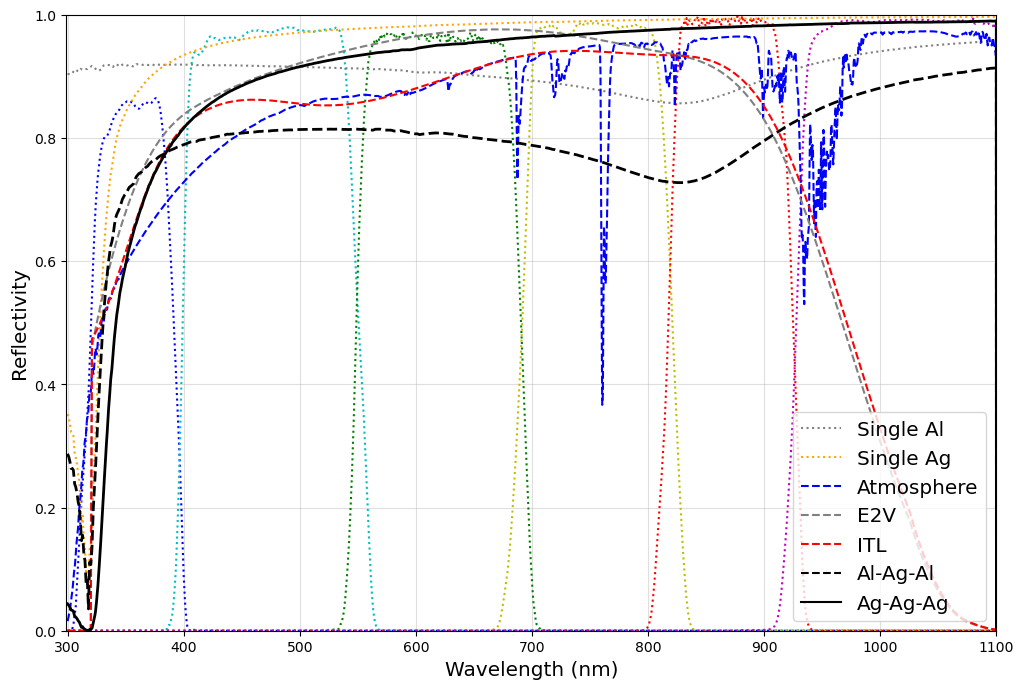

In [13]:
# Plot JUST the mirror reflectivities, for the all Aluminum or all Silver or Al-Ag-Al sets
mirror_plot = [['Al', 'Ag', 'Al'], ['Ag', 'Ag', 'Ag']]

mirrors = {}
for combo in mirror_plot:
    name = '-'.join(combo)
    wavelen = mirror[combo[0]].wavelen
    sb = mirror[combo[0]].sb * mirror[combo[1]].sb * mirror[combo[2]].sb
    mirrors[name] = Bandpass()
    mirrors[name].set_bandpass(wavelen, sb)

   
# Plot the mirror reflectivities
plt.figure(figsize=(12, 8))
st.plotBandpasses(filters, newfig=False, linestyle=':', linewidth=1.5, addlegend=False)
linestyles = ['--', '-']
leg_elements = []

plt.plot(mirror['Al'].wavelen, mirror['Al'].sb, color='gray', linestyle=':')
leg_elements.append(Line2D([0], [0], color='gray', linestyle=':', label='Single Al'))
plt.plot(mirror['Ag'].wavelen, mirror['Ag'].sb,  color='orange', linestyle=':')
leg_elements.append(Line2D([0], [0], color='orange', linestyle=':', label='Single Ag'))

extra= True
if extra:
    plt.plot(atmos.wavelen, atmos.sb,  color='blue', linestyle='--')
    leg_elements.append(Line2D([0], [0], color='blue', linestyle='--', label='Atmosphere'))
    plt.plot(detector['e2v'].wavelen, detector['e2v'].sb,  color='gray', linestyle='--')
    leg_elements.append(Line2D([0], [0], color='gray', linestyle='--', label='E2V'))
    plt.plot(detector['itl'].wavelen, detector['itl'].sb,  color='red', linestyle='--')
    leg_elements.append(Line2D([0], [0], color='red', linestyle='--', label='ITL'))

for i, combo in enumerate(mirror_plot):
    name = '-'.join(combo)
    linestyle= linestyles[i]
    plt.plot(mirrors[name].wavelen, mirrors[name].sb, color='k', linestyle=linestyle, linewidth=2)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=name))


plt.legend(handles=leg_elements, loc='lower right', fontsize='x-large', fancybox=True)
plt.grid(True, alpha=0.4)
plt.xlim(299, 1100)
plt.ylim(0, 1)
#plt.xlim(299, 400)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")

In [14]:
m5['Al-Ag-Al']['e2v']

,nexp,exptime,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,2.0,15.0,0.925108,0.812438,22.957139,100.741943,27.260783,0.045183,0.072036,0.506428,0.038263,23.377155,0.503348,0.309025,24.052989,575.756603,23.9,23.4
g,2.0,15.0,0.874425,0.770778,22.261470,556.188127,28.711562,0.171905,0.209552,0.215009,0.038881,24.637109,0.135837,0.069926,25.026282,893.785296,25.0,24.6
r,2.0,15.0,0.828033,0.732643,21.201014,1115.695630,28.494894,0.140806,0.158283,0.127031,0.039112,24.640773,0.072277,0.035008,24.558906,1125.943716,24.7,24.3
i,2.0,15.0,0.795996,0.706309,20.478342,1562.624124,28.168903,0.104286,0.113939,0.096122,0.039204,24.514436,0.052649,0.024675,24.114075,1256.181360,24.0,23.6
z,2.0,15.0,0.774722,0.688822,19.595368,2322.330561,27.743070,0.070452,0.075085,0.069155,0.039318,24.333411,0.036044,0.016214,23.520975,1465.410540,23.3,22.9
y,2.0,15.0,0.757680,0.674813,18.596982,2954.655202,26.906634,0.032607,0.038087,0.168662,0.039377,23.873833,0.028553,0.012468,22.586354,1604.106132,22.1,21.7


In [15]:
print('srd', srd)
d = pd.DataFrame({'Al-Ag-Al E2V': m5['Al-Ag-Al']['e2v'].m5, 'Al-Ag-Al ITL': m5['Al-Ag-Al']['itl'].m5,
                  'Ag-Ag-Ag E2V': m5['Ag-Ag-Ag']['e2v'].m5, 'Ag-Ag-Ag ITL': m5['Ag-Ag-Ag']['itl'].m5})

d.round(2)

srd True


,Al-Ag-Al E2V,Al-Ag-Al ITL,Ag-Ag-Ag E2V,Ag-Ag-Ag ITL
u,24.05,23.99,23.95,23.89
g,25.03,24.99,25.09,25.06
r,24.56,24.51,24.66,24.61
i,24.11,24.10,24.25,24.24
z,23.52,23.53,23.67,23.68
y,22.59,22.62,22.66,22.69


In [16]:
delta_m5 = (d.T - d['Al-Ag-Al E2V'].T)
delta_m5.round(2).T
# Positive values mean deeper limiting magnitudes

,Al-Ag-Al E2V,Al-Ag-Al ITL,Ag-Ag-Ag E2V,Ag-Ag-Ag ITL
u,0.0,-0.06,-0.10,-0.16
g,0.0,-0.03,0.06,0.03
r,0.0,-0.05,0.10,0.05
i,0.0,-0.02,0.14,0.12
z,0.0,0.01,0.15,0.16
y,0.0,0.03,0.08,0.11


In [17]:
# Effective time calculation
# Fractional change in effective time is proportional to change in m5.
# HERE - longer time = better
dtime = np.power(10, 0.8 * (delta_m5))
dtime

,u,g,r,i,z,y
Al-Ag-Al E2V,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Al-Ag-Al ITL,0.898149,0.938958,0.911455,0.971701,1.012394,1.055759
Ag-Ag-Ag E2V,0.831527,1.126444,1.201341,1.287750,1.323426,1.153729
Ag-Ag-Ag ITL,0.746931,1.057861,1.096938,1.252320,1.338983,1.217235


In [18]:
SRD_time_distribution = pd.Series({'u': 0.068, 'g': 0.097, 'r': 0.223, 'i': 0.223, 'z': 0.194, 'y': 0.194})
SRD_time_distribution 

u    0.068
g    0.097
r    0.223
i    0.223
z    0.194
y    0.194
dtype: float64

In [19]:
weighted_dtime = dtime.multiply(SRD_time_distribution)
weighted_dtime

,u,g,r,i,z,y
Al-Ag-Al E2V,0.068000,0.097000,0.223000,0.223000,0.194000,0.194000
Al-Ag-Al ITL,0.061074,0.091079,0.203255,0.216689,0.196404,0.204817
Ag-Ag-Ag E2V,0.056544,0.109265,0.267899,0.287168,0.256745,0.223823
Ag-Ag-Ag ITL,0.050791,0.102612,0.244617,0.279267,0.259763,0.236144


In [20]:
weighted_dtime.sum(axis=1).round(3)

Al-Ag-Al E2V    0.999
Al-Ag-Al ITL    0.973
Ag-Ag-Ag E2V    1.201
Ag-Ag-Ag ITL    1.173
dtype: float64